# spinal_test4.ipynb

This test is similar to `spinal_test2.ipynb`, and `spinal_test2.ipynb`, but the plant will now be the planar arm.

## PART 1

First we need to obtain a list of desired target muscle lengths.  
To this end, the `bouncy_planar_arm` has two utility functions: `coords_to_angs`, and `coords_to_lengths`. These functions provide respectively the angles and muscle lengths corresponding to given hand coordinates.
The following cells are used to test them.

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
# list with hand coordinates [x,y] (meters)
hand_coords = [[0.3, 0.4], 
               [0.35, 0.35],
               [0.4, 0.3],
               [0.35, 0.25],
               [0.3, 0.2],
               [0.25, 0.25],
               [0.2, 0.3],
               [0.25, 0.35]]

# PARAMETER DICTIONARIES
net_params = {'min_delay' : 0.005,
              'min_buff_size' : 10 }
P_params = {'type' : plant_models.bouncy_planar_arm,
            'mass1' : 0.5,
            'mass2' : 0.5,
            'init_q1' : 0.,
            'init_q2' : np.pi/2.,
            'init_q1p' : 0.,
            'init_q2p' : 0.}

net = network(net_params)
P = net.create(1, P_params)
arm = net.plants[P]

# From coordinates to angles
sh_angs = []
elb_angs = []
for coord in hand_coords:
    angs = arm.coords_to_angs(coord)
    sh_angs.append(angs[0])
    elb_angs.append(angs[1])

ret_coords = []
L1 = arm.l_arm
L2 = arm.l_farm
for sa, ea in zip(sh_angs, elb_angs):
    x = L1*np.cos(sa) + L2*np.cos(sa+ea)
    y = L1*np.sin(sa) + L2*np.sin(sa+ea)
    print("x=%f, y=%f, sa=%f, ea=%f"%(x,y, sa, ea))
    ret_coords.append([x,y])
print(ret_coords)

x=0.300000, y=0.400000, sa=0.341610, ea=1.171371
x=0.350000, y=0.350000, sa=0.184730, ea=1.201337
x=0.400000, y=0.300000, sa=0.057816, ea=1.171371
x=0.350000, y=0.250000, sa=-0.151258, ea=1.543015
x=0.300000, y=0.200000, sa=-0.338136, ea=1.852276
x=0.250000, y=0.250000, sa=-0.155261, ea=1.881318
x=0.200000, y=0.300000, sa=0.056656, ea=1.852276
x=0.250000, y=0.350000, sa=0.179039, ea=1.543015
[[0.30000000000000004, 0.4], [0.35000000000000003, 0.3499999999999999], [0.4, 0.3], [0.35, 0.24999999999999997], [0.3, 0.20000000000000007], [0.25000000000000006, 0.25], [0.20000000000000004, 0.30000000000000004], [0.2500000000000001, 0.3499999999999999]]


In [3]:
coords = [0.3, 0.3]
lens = arm.coords_to_lengths(coords)
lens

array([0.29      , 0.10198039, 0.10198039, 0.30016662, 0.09219544,
       0.10049876])

---

### BONUS CELL
Here are some weights for the M-C and A-M connections that I'd ideally would like to see in PART 2.
* When M and SPF have 6 units each, and SPF has SF-SP:

    MX to CY = 
        1 iff X=Y, 
        0.3 if Y is agonist, 
        0.1 if partial agonist, 
        -0.1 if partial antagonis, 
        -0.4 if antagonist.
    
    
    AX to MY
        (-0.2, -0.3, -0.6) if X corresponds to Y
        (-0.1, -0.2, -0.3) if X corresponds to an agonist of Y
        (-0.1, -0.1, -0.2) if X corresponds to a partial agonist of Y
        (0.1, 0.2, 0.3) if X corresponds to a partial antagonist of Y
        (0.2, 0.3, 0.6) if X corresponds to an antagonist of Y
    
    


In [3]:
A_M = np.zeros((len(M), len(A)))

antagonists = [(0,3), (1,2), (4,5)]
part_antag = [(0,2),(0,5), (3,4), (1,3)]
synergists = [(0,1), (0,4), (2,3), (3,5)]
part_syne = [(1,4), (2,5)]
self_conn = [(x,x) for x in range(6)]

def a_m_connect(A_M, pair_list, weights):
    for pair in pair_list:
        A_M[pair[0], 3*pair[1]] = weights[0]
        A_M[pair[0], 3*pair[1]+1] = weights[1]
        A_M[pair[0], 3*pair[1]+2] = weights[2]
        A_M[pair[1], 3*pair[0]] = weights[0]
        A_M[pair[1], 3*pair[0]+1] = weights[1]
        A_M[pair[1], 3*pair[0]+2] = weights[2]
        
a_m_connect(A_M, self_conn, (-0.2, -0.3, -0.6))
a_m_connect(A_M, synergists, (-0.1, -0.2, -0.3))
a_m_connect(A_M, part_syne, (-0.1, -0.1, -0.2))
a_m_connect(A_M, part_antag, (0.1, 0.2, 0.3))
a_m_connect(A_M, antagonists, (0.2, 0.3, 0.6))


A_M

NameError: name 'M' is not defined

In [10]:
M_C = np.zeros((len(C), len(M)))

for x in range(len(M)):
    M_C[x,x] = 1.
    for pair in antagonists:
        if x == pair[0]:
            M_C[x, pair[1]] = -0.4
            M_C[pair[1], x] = -0.4
    for pair in part_antag:
        if x == pair[0]:
            M_C[x, pair[1]] = -0.1
            M_C[pair[1], x] = -0.1
    for pair in synergists:
        if x == pair[0]:
            M_C[x, pair[1]] = 0.3
            M_C[pair[1], x] = 0.3
    for pair in part_syne:
        if x == pair[0]:
            M_C[x, pair[1]] = 0.1
            M_C[pair[1], x] = 0.1
            
M_C

array([[ 1. ,  0.3, -0.1, -0.4,  0.3, -0.1],
       [ 0.3,  1. , -0.4, -0.1,  0.1,  0. ],
       [-0.1, -0.4,  1. ,  0.3,  0. ,  0.1],
       [-0.4, -0.1,  0.3,  1. , -0.1,  0.3],
       [ 0.3,  0.1,  0. , -0.1,  1. , -0.4],
       [-0.1,  0. ,  0.1,  0.3, -0.4,  1. ]])

In [10]:
A_M

array([[-0.2, -0.3, -0.6, -0.1, -0.2, -0.3,  0.1,  0.2,  0.3,  0.2,  0.3,
         0.6, -0.1, -0.2, -0.3,  0.1,  0.2,  0.3],
       [-0.1, -0.2, -0.3, -0.2, -0.3, -0.6,  0.2,  0.3,  0.6,  0.1,  0.2,
         0.3, -0.1, -0.1, -0.2,  0. ,  0. ,  0. ],
       [ 0.1,  0.2,  0.3,  0.2,  0.3,  0.6, -0.2, -0.3, -0.6, -0.1, -0.2,
        -0.3,  0. ,  0. ,  0. , -0.1, -0.1, -0.2],
       [ 0.2,  0.3,  0.6,  0.1,  0.2,  0.3, -0.1, -0.2, -0.3, -0.2, -0.3,
        -0.6,  0.1,  0.2,  0.3, -0.1, -0.2, -0.3],
       [-0.1, -0.2, -0.3, -0.1, -0.1, -0.2,  0. ,  0. ,  0. ,  0.1,  0.2,
         0.3, -0.2, -0.3, -0.6,  0.2,  0.3,  0.6],
       [ 0.1,  0.2,  0.3,  0. ,  0. ,  0. , -0.1, -0.1, -0.2, -0.1, -0.2,
        -0.3,  0.2,  0.3,  0.6, -0.2, -0.3, -0.6]])

In [12]:
1./(1. + np.exp(2))

0.11920292202211755

# PART 2
Muscle lengths control.

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
##################################
####### Create the network #######
##################################

# First the network object, the plant, the list of coordinates
net_params = {'min_delay' : 0.005,
              'min_buff_size' : 10 }
P_params = {'type' : plant_models.bouncy_planar_arm,
            'mass1' : 0.5,
            'mass2' : 0.5,
            'smin' : -0.4, # minimum shoulder angle (rads)
            'p1' : (-0.01, 0.05),
            'p3' : (0.0, 0.05),
            'init_q1' : np.pi/4.,
            'init_q2' : np.pi/2.,
            'init_q1p' : 0.,
            'init_q2p' : 0.,
            'g' : 0.,
            'mu1' : .2,
            'mu2' : .2,
            'l_torque' : 0.01,
            'l_visco' : 0.05,
            'm_gain' : 2.,
            'l_gain' : 2.,
            'v_gain' : 5.,
            'spring' : 2.,
            'tau' : 0.01 } # ficticious time constant used in create_freqs_steps
net = network(net_params)
P = net.create(1, P_params)
arm = net.plants[P]

# We organize the spinal connections through 4 types of symmetric relations
# these lists are used to set intraspinal connections and test connection matrices
antagonists = [(0,3), (1,2), (4,5)]
part_antag = [(0,2),(0,5), (3,4), (1,3)]
synergists = [(0,1), (0,4), (2,3), (3,5)]
part_syne = [(1,4), (2,5)]
self_conn = [(x,x) for x in range(6)]

# PARAMETER DICTIONARIES
par_heter = 0.1 # range of heterogeneity as a fraction of the original value
randz1 = lambda : (1. + par_heter*(np.random.rand()-0.5))
randz6 = lambda : (1. + par_heter*(np.random.rand(6)-0.5))
randz12 = lambda : (1. + par_heter*(np.random.rand(12)-0.5))
randz18 = lambda : (1. + par_heter*(np.random.rand(18)-0.5))

SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.6 * randz6(),
             'slope' : 4. * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.03 * randz6() } 
SP_params = {'type' : unit_types.source,
             'init_val' : 0.5,
             'function' : lambda t: None }
SPF_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.5 * randz6(),
              'slope' : 5. * randz6(),
              'init_val' : 0.3 * randz6(),
              'tau_fast': 0.005,
              'tau_mid': 0.05,
              'tau_slow' : 5.,
              'tau' : 0.02 * randz6() }
M_params = {'type' : unit_types.out_norm_am_sig,
            'thresh' : -0.1 * randz6(),
            'slope' : 3. * randz6(),
            'init_val' : 0.2 * randz6(),
            'delay' : 0.2,
            'tau_fast': 0.01,
            'tau_mid': 0.05,
            'tau_slow' : 2.,
            'tau' : 0.01 * randz6(),
            'des_out_w_abs_sum' : 1. }
init_base = np.array([0.5, 0.5, 2.*np.pi, 0.5])
C_params = {'type' : unit_types.am_pm_oscillator,
            'integ_meth' : 'odeint',
            'tau_u' : 0.4 * randz6(),
            'tau_c' : 10000. * randz6(),
            'tau_t' : 1.,
            'tau_s' : 0.02,
            'init_val' : init_base, #[r*init_base for r in np.random.random(6)],
            'multidim' : True,
            'omega' : .5*np.pi * randz6(),
            'F' : 'zero', #'input_sum',
            'tau_fast': 0.01,
            'tau_mid' : 0.05,
            'tau_slow' : 2.,
            'custom_inp_del' : 150,
            'delay' : 0.2,
            'mu' : 0.,
            'sigma' : 0.0 }
A_params = {'type' : unit_types.logarithmic,
            'init_val' : 0.,
            'tau' : 0.02 * randz18(),
            'tau_fast': 0.005,
            'thresh' : [-0.6, -0.3, 0.5,
                         -1.1, -0.3, 0.5,
                         -0.3, -0.3, 0.5,
                         -0.5, -0.3, 0.5,
                         -0.4, -0.3, 0.5,
                         -1.2, -0.3, 0.5] } # length afferents report l/l0
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }

# CONNECTION DICTIONARIES
SFe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SFi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SFe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SFi__SPF_syn = {'type' : synapse_types.static,
                'init_w' : -1. }
SPe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SPi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SPe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SPi__SPF_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
SPF__M_conn = {'rule': 'one_to_one',
               'delay': 0.01 }
SPF__M_syn = {'type' : synapse_types.static, #synapse_types.inp_corr,
              'inp_ports' : 1,
              'lrate' : 0.,
              'input_type' : 'error', # if using inp_corr
              'init_w' : 2. }
# motor to spinal connections
# creating a test matrix
M_C = np.zeros((6, 6))
for x in range(6):
    M_C[x,x] = 1.
    for pair in antagonists:
        if x == pair[0]:
            M_C[x, pair[1]] = -0.4
            M_C[pair[1], x] = -0.4
    for pair in part_antag:
        if x == pair[0]:
            M_C[x, pair[1]] = -0.1
            M_C[pair[1], x] = -0.1
    for pair in synergists:
        if x == pair[0]:
            M_C[x, pair[1]] = 0.3
            M_C[pair[1], x] = 0.3
    for pair in part_syne:
        if x == pair[0]:
            M_C[x, pair[1]] = 0.1
            M_C[pair[1], x] = 0.1
M_C = 0.4*(np.random.random((6,6)) - 0.5) # random initial connections!!!!
M__C_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__C_syn = {'type' : synapse_types.rga,
            'lrate': 50., #40.,
            'inp_ports': 0,
            'init_w' : M_C.flatten() } #{'distribution':'uniform', 'low':0.05, 'high':.1} }
# spinal units to plant
C__P_conn = {'inp_ports' : list(range(0,18,3)),
             'delays': 0.01 }
C__P_syn = {'type': synapse_types.static,
            'init_w' : 2. } #1.5 }
# afferents to motor
## Creating a test matrix
A_M = np.zeros((6, 18))
def a_m_connect(A_M, pair_list, weights):
    for pair in pair_list:
        A_M[pair[0], 3*pair[1]] = weights[0]
        A_M[pair[0], 3*pair[1]+1] = weights[1]
        A_M[pair[0], 3*pair[1]+2] = weights[2]
        A_M[pair[1], 3*pair[0]] = weights[0]
        A_M[pair[1], 3*pair[0]+1] = weights[1]
        A_M[pair[1], 3*pair[0]+2] = weights[2]        
a_m_connect(A_M, self_conn, (-0.2, -0.3, -0.6))
a_m_connect(A_M, synergists, (-0.1, -0.2, -0.3))
a_m_connect(A_M, part_syne, (-0.1, -0.1, -0.2))
a_m_connect(A_M, part_antag, (0.1, 0.2, 0.3))
a_m_connect(A_M, antagonists, (0.2, 0.3, 0.6))
A_M = A_M.transpose()
A_M = 0.2*(np.random.random((18,6)) - 0.5) # random initial connections!!!!
A__M_conn = {'rule' : 'all_to_all',
             'delay' : 0.02 }
A__M_syn = {'type' : synapse_types.inp_sel, #synapse_types.inp_corr,
            'aff_port' : 0,
            'error_port' : 1,
            'inp_ports' : 0, # afferent for out_norm_am_sig
            'input_type' : 'pred', # if using inp_corr
            'lrate' : 10.,
            'init_w' : A_M.flatten() } #.1 }
# length afferents to sensory
A__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
A__SF_syn = {'type' : synapse_types.static,
             'init_w' : 2. }
# plant to sensory
"""
P__SF_conn = {'port_map' : [(0,0)],
              'delays' : 0.01 }
P__SF_syn = {'type' : synapse_types.static,
             'init_w' : 1. }
"""
# plant to afferents
bool_aff = [False] * 4 + [False, True, True, True] * 6
idx_aff = np.arange(28)[bool_aff] # indexes for afferent output in the arm
P__A_conn = {'port_map' : [[(p,0)] for p in idx_aff],
             'delays' : 0.02 }
P__A_syn = {'type' : synapse_types.static,
            'init_w' : [2., 2., 1.]*6 }
# lateral connections in C
C__C_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.015 }
C__C_syn_antag = {'type' : synapse_types.corr_inh,
                  'inp_ports': 1,
                  'init_w' : -1.,
                  'lrate' : 0.5,
                  'des_act' : 0.5 }
C__C_syn_p_antag = {'type' : synapse_types.corr_inh,
                  'inp_ports': 1,
                  'init_w' : -.4,
                  'lrate' : 0.5,
                  'des_act' : 0.5 }
C__C_syn_syne = {'type' : synapse_types.static,
                 'inp_ports': 1,
                 'init_w' : .8 }
C__C_syn_p_syne = {'type' : synapse_types.static,
                   'inp_ports': 1,
                   'init_w' : 0.4 }

def create_freqs_steps(n, w, r):
    """ Returns a 2-tuple with the lists required for heterogeneous frequencies.
    
        We assume that the important loop for the learning rule in the C units
        is the one going through C-P-M-C
        Args:
            n : number of units
            w : base omega value (rad)
            r : amplitude of noise as fraction of original value
        Returns
            2-tuple : (freqs, steps)
            freqs : a list with n angular frequencies.
            steps : a list with the corresponding delays as number of steps. 
    """
    ws = w * (1. + r*((np.random.random(n) - 0.5)))
    ws = ws / C_params['tau_t'] # angular frequencies
    cp_del = np.arctan(np.mean(P_params['tau'])*ws)/ws
    pa_del = np.arctan(np.mean(A_params['tau'])*ws)/ws
    am_del = np.arctan(np.mean(M_params['tau'])*ws)/ws
    D = [C__P_conn['delays'], np.mean(P__A_conn['delays']),
         A__M_conn['delay'], M__C_conn['delay'] ]
    d1 = cp_del + pa_del + am_del + sum(D)
    del_steps = [int(d) for d in np.ceil(d1/net_params['min_delay'])]
    return (list(ws), del_steps)

# CREATING UNITS
SF = net.create(6, SF_params)
SP = net.create(6, SP_params)
SPF = net.create(6, SPF_params)
M = net.create(6, M_params)
A = net.create(18, A_params)
# creating C with heterogeneous frequencies
omegas, del_steps = create_freqs_steps(6, C_params['omega'], par_heter)
C_params['omega'] = omegas
C_params['custom_inp_del'] = del_steps
C = net.create(6, C_params)

# SET THE PATTERNS IN SP
t_pres = 15. # number of seconds to hold each set of target lengths
# list with hand coordinates [x,y] (meters)
hand_coords = [[0.3, 0.45], 
               [0.35, 0.4],
               [0.4, 0.35],
               [0.35, 0.3],
               [0.3, 0.25],
               [0.25, 0.3],
               [0.2, 0.35],
               [0.25, 0.4]]
# list with muscle lengths corresponding to the hand coordinates
m_lengths = []
for coord in hand_coords:
    m_lengths.append(arm.coords_to_lengths(coord))
# We need to translate these lengths to corresponding SF activity levels.
# For that it is necessary to recreate all their transformations
# The first transformation is from length to Ia activity in the muscle object
l = np.array([net.plants[P].muscles[i].l0 for i in range(6)]) # resting lengths
m_lengths = P_params['l_gain']*(m_lengths - l) / l
# Next transformation is through the logarithmic afferent units
l_arg = (P__A_syn['init_w'][0]*m_lengths) - np.array(A_params['thresh'][0:16:3])
l_affs = np.log(1. + np.maximum(0., l_arg))
# Next is from AF to SF
sf_arg = A__SF_syn['init_w']*l_affs
sf_preds = 1./ (1. + np.exp(-np.mean(SF_params['slope'])*(sf_arg - np.mean(SF_params['thresh']))))
m_idxs = np.random.randint(len(hand_coords), size=1000) # index of target lengths

def make_fun(idx):
    """ create a function for the SP unit with index 'idx'. """
    return lambda t: sf_preds[m_idxs[int(np.floor(t/t_pres))]][idx]
for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))

# tracking units
M_C0_track = net.create(len(M), track_params) # to track weights from M to C0
A_M0_track = net.create(18, track_params) # to track weights from A to M0
xp_track = net.create(1, track_params) # del_avg_inp_deriv of C0 at port 1
up_track = net.create(1, track_params) # to track the derivative of C0
sp_track = net.create(1, track_params) # avg_inp_deriv_mp for C0 at port 0
spj_track = net.create(1, track_params) # input derivative for MX--C0
ipx_track = net.create(12, track_params) # x coordinates of insertion points
ipy_track = net.create(12, track_params) # y coordinates of insertion points

# CONNECTING
# from M to C
net.connect(M, C, M__C_conn, M__C_syn) # should be made before C-->C
# from C to P
net.set_plant_inputs(C, P, C__P_conn, C__P_syn)
# from P to A
net.set_plant_outputs(P, A, P__A_conn, P__A_syn)
# from A to SF. Only the length afferents are selected
A_len = [A[i] for i in range(0,18,3)]
net.connect(A_len, SF, A__SF_conn, A__SF_syn)
# from A to M
net.connect(A, M, A__M_conn, A__M_syn) # should be made before SPF-->M
# from SF, SP to SPF
net.connect(SF, SPF[0:6], SFe__SPF_conn, SFe__SPF_syn)
#net.connect(SF, SPF[6:12], SFi__SPF_conn, SFi__SPF_syn) 
net.connect(SP, SPF[0:6], SPi__SPF_conn, SPi__SPF_syn)
#net.connect(SP, SPF[6:12], SPe__SPF_conn, SPe__SPF_syn)
# from SPF to M
net.connect(SPF, M, SPF__M_conn, SPF__M_syn) # should be after A-->M
# intraspinal connections
syn_dicts = [C__C_syn_antag, C__C_syn_p_antag, C__C_syn_syne, C__C_syn_p_syne]
pair_lists = [antagonists, part_antag, synergists, part_syne] # order should match list above
for pair_list, syn_dict in zip(pair_lists, syn_dicts):
    firsts = [C[p[0]] for p in pair_list]
    seconds = [C[p[1]] for p in pair_list]
    net.connect(firsts, seconds, C__C_conn, syn_dict)
    net.connect(seconds, firsts, C__C_conn, syn_dict)

# SETTING UP WEIGHT TRACKING -- depends on the order of statements above!!!!!!
# This assumes the first connections to C are M-->C
def M_C0_fun(idx):
    """ Creates a function to track a weight from M to C0. """
    return lambda t: net.syns[C[0]][idx].w
for idx in range(len(M)):
    net.units[M_C0_track[idx]].set_function(M_C0_fun(idx))
# This assumes the first connections to M are A-->M    
def A_M0_fun(idx):
    """ Creates a function to track a weight from A to M0. """
    return lambda t: net.syns[M[0]][idx].w
for idx in range(18):
    net.units[A_M0_track[idx]].set_function(A_M0_fun(idx))

# SETTING TRACKING OF PLASTICITY FACTORS FOR MX-->C0
X = 0 # index of the M unit we'll monitor
net.units[xp_track[0]].set_function(lambda t: net.units[C[0]].del_avg_inp_deriv_mp[1])
po_de = net.units[C[0]].custom_inp_del
net.units[up_track[0]].set_function(lambda t: net.units[C[0]].get_lpf_fast(po_de) - 
                                    net.units[C[0]].get_lpf_mid(po_de))
net.units[sp_track[0]].set_function(lambda t: net.units[C[0]].avg_inp_deriv_mp[0])
ds = net.syns[C[0]][0].delay_steps
net.units[spj_track[0]].set_function(lambda t: net.units[M[X]].get_lpf_fast(ds) - 
                                     net.units[M[X]].get_lpf_mid(ds))

# TRACKING OF INSERTION POINTS (for the arm animation)
# make the source units track the tensions
def create_xtracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][0]
def create_ytracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][1]
for idx, uid in enumerate(ipx_track):
    net.units[uid].set_function(create_xtracker(P, idx))
for idx, uid in enumerate(ipy_track):
    net.units[uid].set_function(create_ytracker(P, idx))

In [3]:
start_time = time.time()
times, data, plant_data  = net.flat_run(100.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

Execution time is 91.3580892086029 seconds


[0.03778882 0.0024242  0.14326446 0.08236749 0.39590546 0.07286109]
[0.03307502 0.00188117 0.09073467 0.09109884 0.29087575 0.06379362]


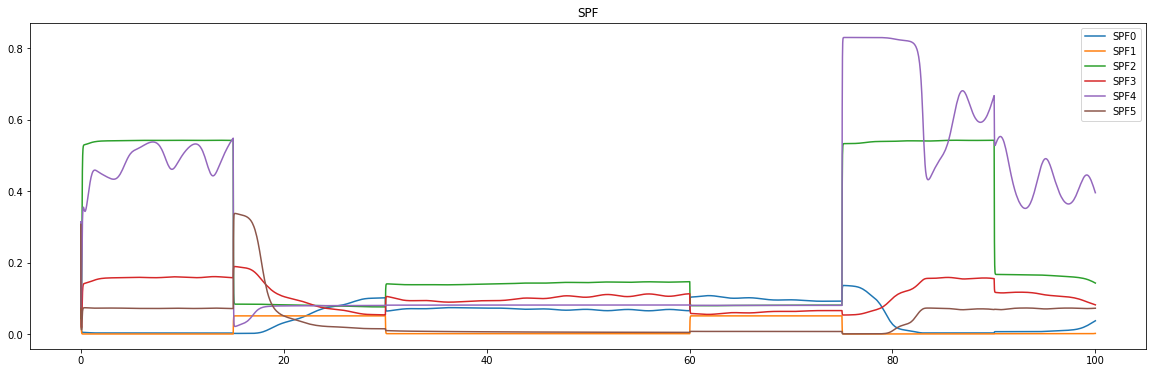

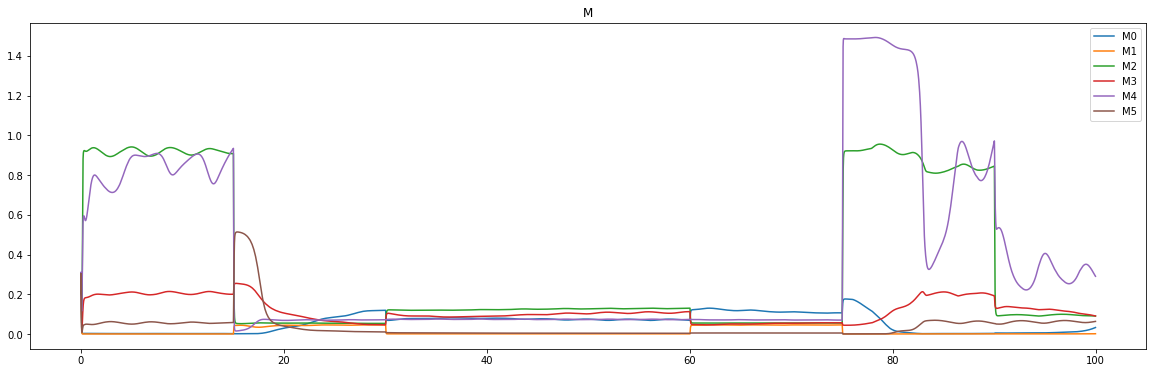

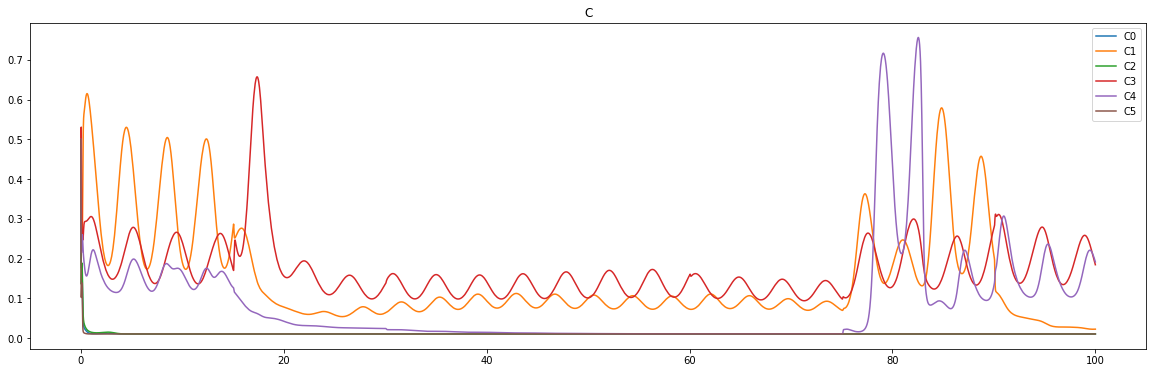

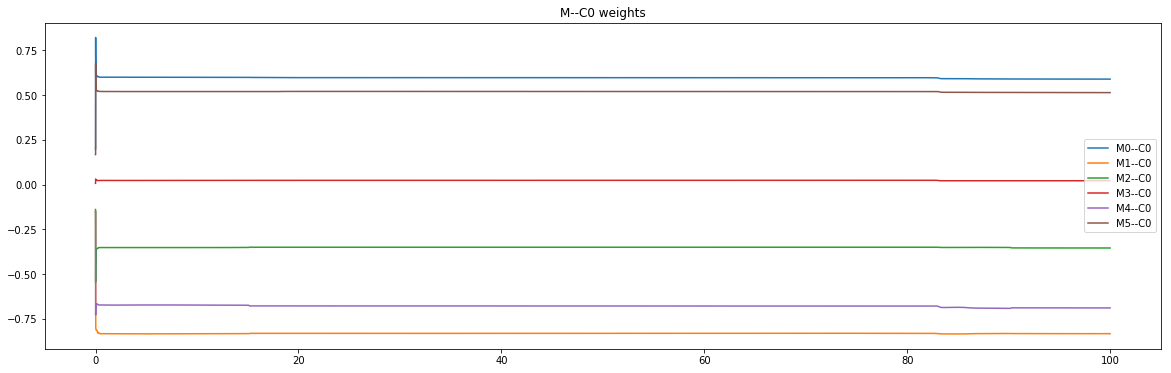

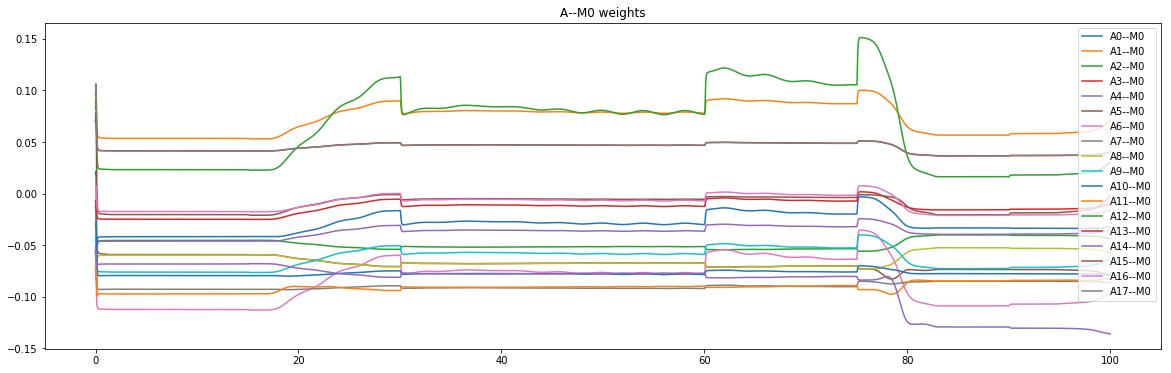

In [4]:
arm_activs = plant_data[P]
# SPF
fs = (20,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
SPF_legends = ['SPF'+str(i) for i in range(len(SPF))]
plt.legend(SPF_legends)
plt.title('SPF')
print(SPF_data[:,-1])

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
M_legends = ['M'+str(i) for i in range(len(M))]
plt.legend(M_legends)
plt.title('M')
print(M_data[:,-1])

# C
C_fig = plt.figure(figsize=fs)
C_data = np.array(data[C])
plt.plot(times, C_data.transpose())
C_legends = ['C'+str(i) for i in range(len(C))]
plt.legend(C_legends)
plt.title('C')

# M--C0 weights
W_fig1 = plt.figure(figsize=fs)
w_track_data = np.array(data[M_C0_track])
plt.plot(times, w_track_data.transpose())
M_C0_legends = ['M'+str(i)+'--C0' for i in range(len(M_C0_track))]
plt.legend(M_C0_legends)
plt.title('M--C0 weights')

# A--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2 = np.array(data[A_M0_track])
plt.plot(times, w_track_data2.transpose())
A_M0_legends = ['A'+str(i)+'--M0' for i in range(len(A_M0_track))]
plt.legend(A_M0_legends)
plt.title('A--M0 weights')

plt.show()

A_data:
[2.56097654e-001 3.14533024e-001 9.38724727e-323 1.24155757e-001
 3.30614789e-001 2.00294241e-220 7.05998768e-001 2.14992875e-001
 9.88131292e-323 5.49640029e-001 2.24553361e-001 2.51904800e-001
 4.17646950e-001 2.44854551e-001 2.49859074e-001 7.51937742e-001
 2.74920904e-001 9.38724727e-323]


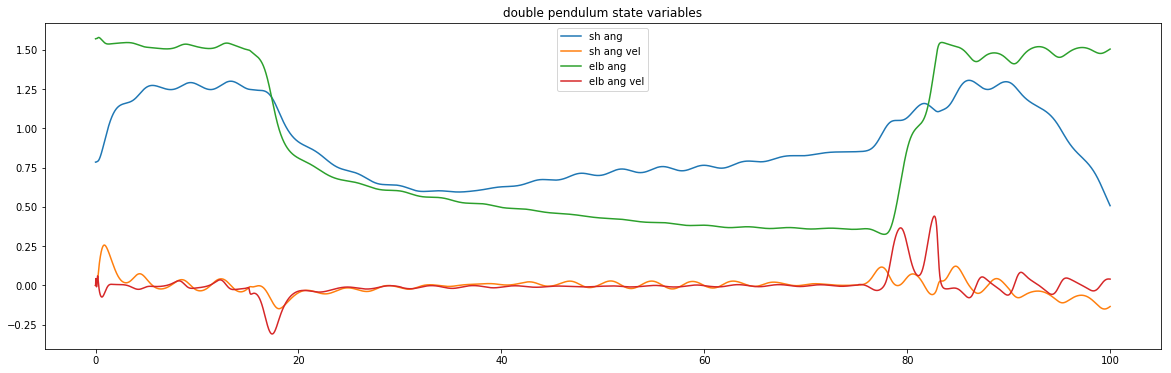

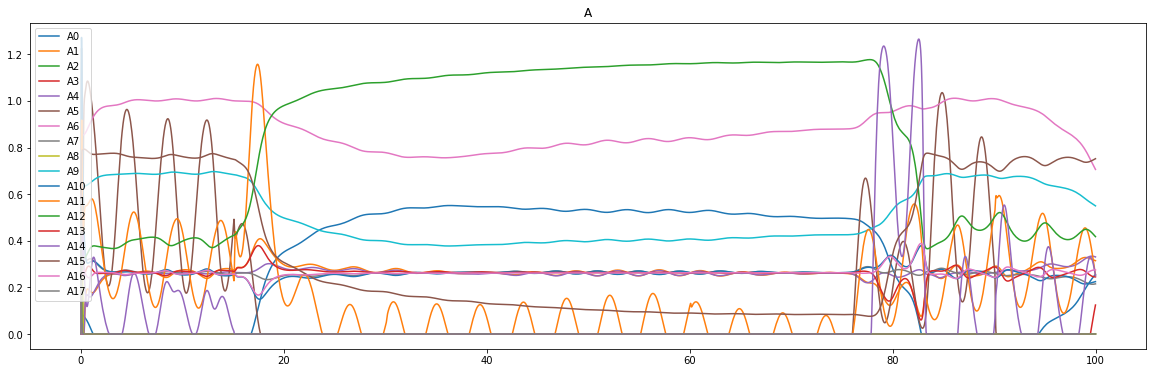

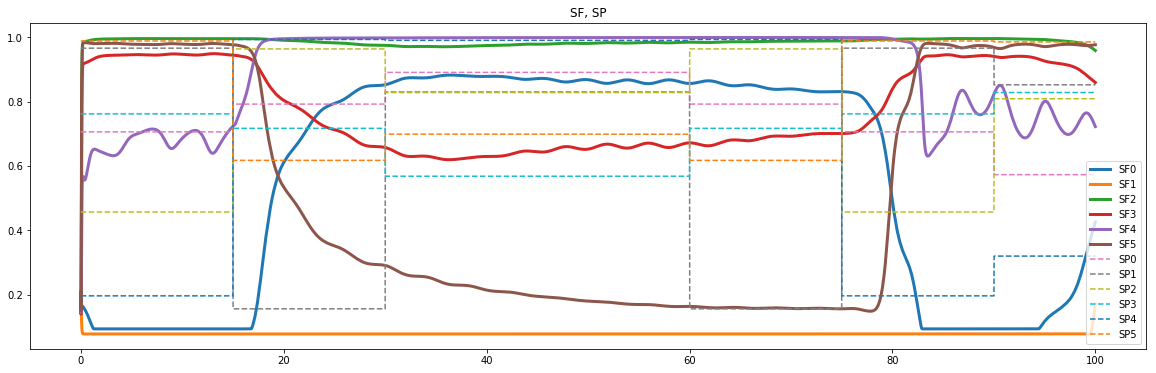

SF = 
[0.42574866 0.17009661 0.95828368 0.85898945 0.72206576 0.97637598]
SP = 
[0.57275544 0.85188911 0.80862695 0.82799782 0.31984437 0.98509035]


In [5]:
# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data[P][:,0:4]
plt.plot(times, P_state)
plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.title('double pendulum state variables')
#print("angle: %f, vel: %f" % (P_data[-1,0],P_data[-1,1]))

# A
A_fig = plt.figure(figsize=fs)
A_data = np.array(data[A])
plt.plot(times, A_data.transpose())
A_legends = ['A'+str(i) for i in range(len(A))]
plt.legend(A_legends)
plt.title('A')
print('A_data:')
print(A_data[:,-1])

# SF, SP
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), linewidth=3)
plt.plot(times, SP_data.transpose(), '--')
SF_legends = ['SF'+str(i) for i in range(len(SF))]
SP_legends = ['SP'+str(i) for i in range(len(SP))]
plt.legend(SF_legends+SP_legends)
plt.title('SF, SP')
plt.show()
print('SF = ')
print(SF_data[:,-1])
print('SP = ')
print(SP_data[:,-1])

X=0


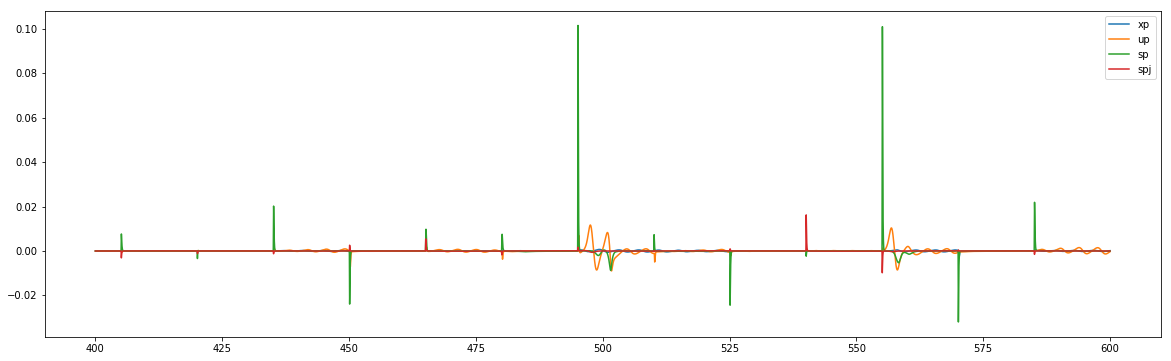

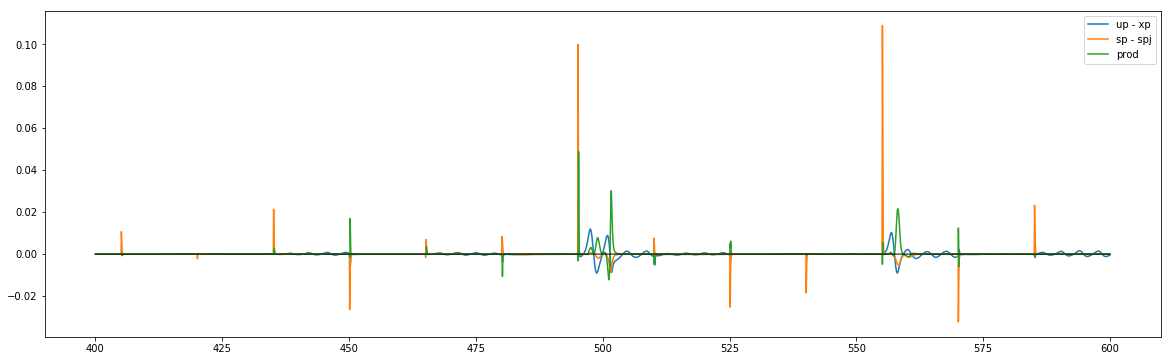

In [15]:
# plot all factors in the MX--C0 synaptic plasticity
print('X=%d' % (X))
fs = (20,6)
plastic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_data = np.array(data[sp_track[0]])
spj_data = np.array(data[spj_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_data)
plt.plot(times, spj_data)
plt.legend(['xp', 'up', 'sp', 'spj'])

plastic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
f2 = sp_data - spj_data
rule = 500. * f1 * f2
plt.plot(times, f1)
plt.plot(times, f2)
plt.plot(times, rule)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'sp - spj', 'prod'])
plt.show()

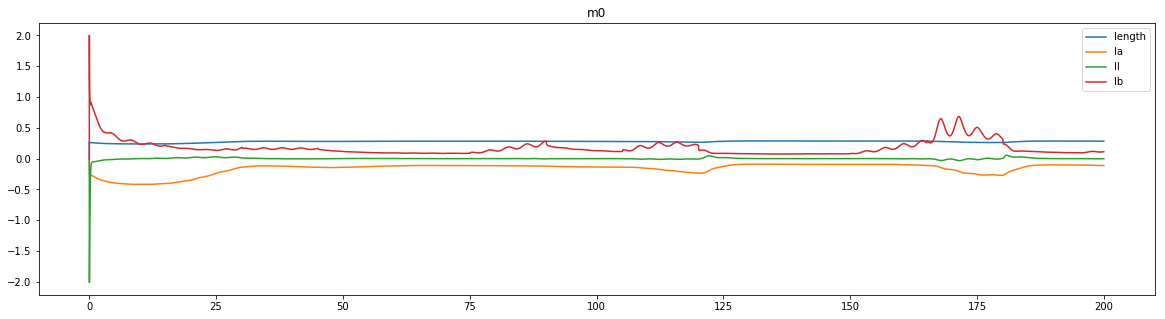

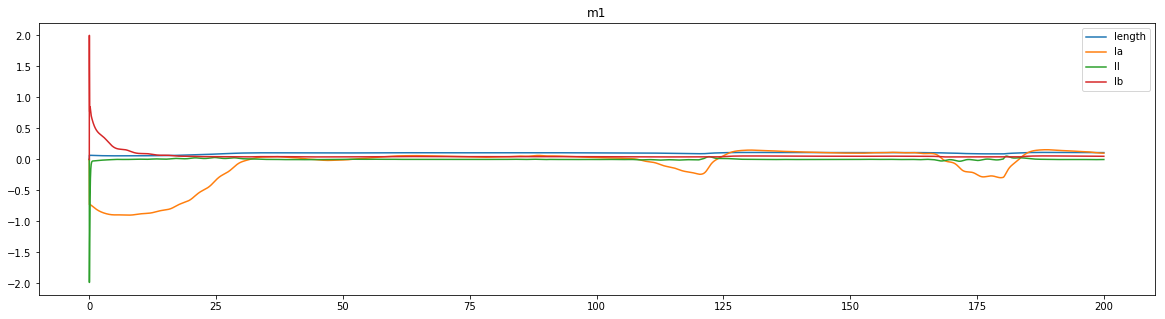

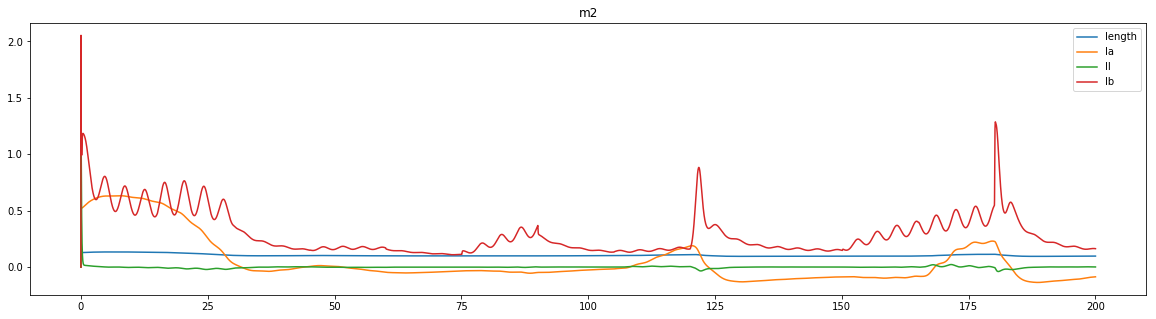

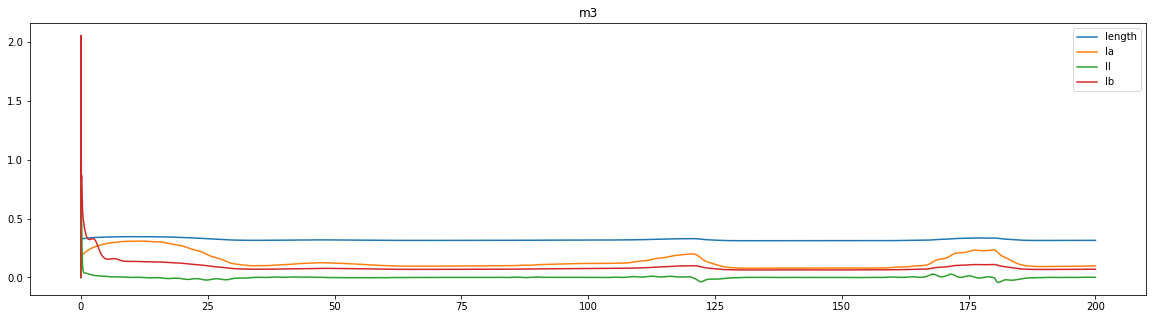

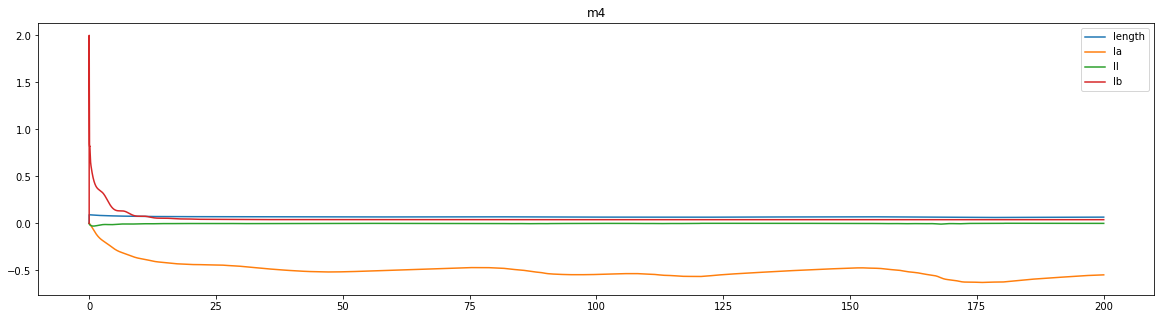

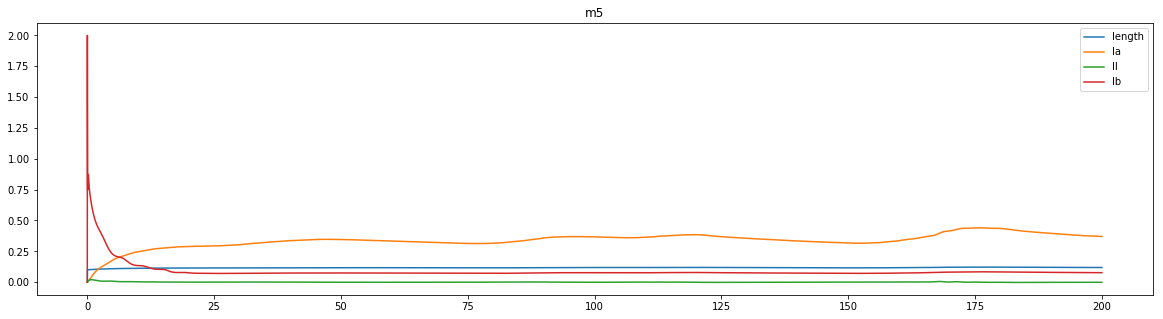

In [7]:
# plotting muscle outputs
fs = (20,5)
legs = ['length', 'Ia', 'II', 'Ib']

for i in range(6):
    next_fig = plt.figure(figsize=fs)
    affs = arm_activs[:,4+4*i:8+4*i]
    plt.plot(times, affs)
    plt.legend(legs)
    plt.title('m' + str(i))
plt.show()

In [16]:
# checking some connections
print("Connections to motor units")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to afferent units")
for idx, syn in enumerate(net.syns[A[2]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to spinal units")
for idx, syn in enumerate(net.syns[C[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> C, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))
print("-------------------------\n")

print("Connections to SF units")
for idx, syn in enumerate(net.syns[SF[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> SF, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

Connections to motor units
0) A (24) --> M, w=0.053535, port=0, plant_out=None
1) A (25) --> M, w=0.076723, port=0, plant_out=None
2) A (26) --> M, w=-0.048852, port=0, plant_out=None
3) A (27) --> M, w=0.043925, port=0, plant_out=None
4) A (28) --> M, w=-0.014908, port=0, plant_out=None
5) A (29) --> M, w=0.007358, port=0, plant_out=None
6) A (30) --> M, w=-0.173404, port=0, plant_out=None
7) A (31) --> M, w=-0.159308, port=0, plant_out=None
8) A (32) --> M, w=-0.070982, port=0, plant_out=None
9) A (33) --> M, w=-0.056340, port=0, plant_out=None
10) A (34) --> M, w=-0.086716, port=0, plant_out=None
11) A (35) --> M, w=0.026519, port=0, plant_out=None
12) A (36) --> M, w=0.036573, port=0, plant_out=None
13) A (37) --> M, w=-0.019398, port=0, plant_out=None
14) A (38) --> M, w=0.041408, port=0, plant_out=None
15) A (39) --> M, w=0.001185, port=0, plant_out=None
16) A (40) --> M, w=-0.079663, port=0, plant_out=None
17) A (41) --> M, w=0.003203, port=0, plant_out=None
18) SPF (12) --> M, 

---

In [17]:
#Animation of the arm and muscles
%matplotlib widget
from numpy import cos, sin
from matplotlib.animation import FuncAnimation

# angles of shoulder and elbow
theta_s = arm_activs[:,0]
theta_e = arm_activs[:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# data from tracking units
acts = np.array(data[1])
ipx = data[ipx_track]
ipy = data[ipy_track]
ten = arm_activs[:, np.array(range(7, 28, 4))].transpose()
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = cos(theta_s)*l1
ye = sin(theta_s)*l1
xh = xe + cos(phi)*l2
yh = ye + sin(phi)*l2
# creating the figure and axis
fig = plt.figure(figsize=(10,10))
plt.axis('equal')
ax = plt.gca()
lim = l1 + l2
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.grid()
# creating lines and points
line, = ax.plot([], [], 'o-b', lw=2)
points, = ax.plot([], [], '+k')
target, = ax.plot([], [], 'gD')
# preparing a colormap for the tensions
ten_max = max(ten.max(), 1e-5)
ten_min = min(ten.min(), -1e-5)
for row_idx, row in enumerate(ten):
    for ent_idx, entry in enumerate(row):
        if entry > 0:
            ten[row_idx, ent_idx] = entry/ten_max
        else:
            ten[row_idx, ent_idx] = entry/abs(ten_min)
#ten = (ten / 2.) + 0.5 # we'll have only positive tensions
mus_lines = []
#cmap=plt.get_cmap('Reds')
#cmap=plt.get_cmap('coolwarm')
cmap=plt.get_cmap('bwr')
for i in range(6):
    mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
# stuff used to plot the target
strt_idx = int(np.round(times[0]/t_pres)) # initial index in m_idxs

def init():
    line.set_data([], [])
    points.set_data([], [])
    for i in range(6):
        mus_lines = []
        mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
    return line, points, mus_lines

def update(frame):
    coord_x = [0, xe[frame], xh[frame]]
    coord_y = [0, ye[frame], yh[frame]]
    ip_x = ipx[:,frame]
    ip_y = ipy[:,frame]
    tens = ten[:, frame]
    line.set_data(coord_x, coord_y)
    points.set_data(ip_x, ip_y)
    for i, ml in enumerate(mus_lines):
        idx = 2*i
        ml.set_data(ip_x[idx:idx+2], ip_y[idx:idx+2])
        ml.set_color(cmap(tens[i]))
    
    cur_time = frame*net.min_delay
    fig.suptitle('time: ' + '{:f}'.format(cur_time))
    # plotting target
    cur_idx = int(cur_time/t_pres) + strt_idx
    x_coord, y_coord = hand_coords[m_idxs[cur_idx]]
    target.set_data([x_coord], [y_coord])
    
    return line, points, muls_lines #muscle1

ani = FuncAnimation(fig, update, frames=np.arange(0, len(theta_s), 8), init_func=init, blit=True, interval=20)

plt.show()

FigureCanvasNbAgg()

In [11]:
ipx.shape

(12, 4000)